## Load, Join, and Export Data

11/2/2017

Provenance of the Data: California Housing Travel Survey

## Table of Contents

### [0. Imported Modules](#Imported-Modules)
### [1. Load Data](#Load-Data)
### [2. Join Data](#Join-Data)
### [3. Predicting Vehicle Type](#Predicting-Vehicle-Type)

### Imported Modules
[Top](#Table-of-Contents)

In [2]:
# Tables, Queries, and Stats
import pandas as pd
import numpy as np

# Plotting
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sbn

# Computational Performance
import time

# OS, path, system access
import os
import os.path

### Load Data
[Top](#Table-of-Contents)

### There are 9 different Survey Tables in the CHTS

In [3]:
def get_tables_in(data_dir):
    print('Path to data on local machine: {}'.format(os.getcwd() + data_dir))
    tables_caltrans = [files for root, dirs, files in os.walk(os.getcwd() +\
                                                    data_dir, topdown=True, followlinks=False)][0]
    return tables_caltrans

In [4]:
#caltrans_tables = get_tables_in('/caltrans_full_survey/')
# Not all data fits in github, so download the data and load from outside the Repo:
caltrans_tables = get_tables_in('/../caltrans_full_survey/')

Path to data on local machine: /Users/vikram/cal/caltravel/../caltrans_full_survey/


In [5]:
def make_dfs_from_files(file_list, table_type, data_dir='../caltrans_full_survey/'):
    ''' Create Pandas DataFrames from the list of data files in CHTS. The 
    table_type signifies the group that the data belongs to.
    Possible groups: Surveys, Vehicles, Wearables
    
    Parms:
        file_list - all files in the survey
        table_type - survey, vehicle, wearable, or trip-level data
        data_dir - 
    Returns:
        
    '''
    start = time.time()
    subset_tables = {}
    if table_type == 'survey tables':
        subset = [file for file in file_list if file.startswith('survey_')]
    elif table_type == 'vehicle tables':
        subset = [file for file in file_list if file.startswith('v_')]
    elif table_type == 'wearable tables':
        subset = [file for file in file_list if file.startswith('w_')]
    elif table_type == 'trip-level tables':
        # Trip-level details are given via an OBD Engine sensor in each vehicle
        subset = [file for file in file_list if file.startswith('obd_')]
    else:
        print('Error: Please check name of table type.')
        return
    for file in subset:
        df = pd.read_csv(data_dir + file, low_memory=False)
        subset_tables[file] = df
    end = time.time()
    print('Loading the {} took {:.3f} seconds.'.format(table_type, end - start))
    return subset_tables

In [6]:
survey_tables = make_dfs_from_files(caltrans_tables, table_type='survey tables')
vehicle_tables = make_dfs_from_files(caltrans_tables, table_type='vehicle tables')
wearable_tables = make_dfs_from_files(caltrans_tables, table_type='wearable tables')
trip_level_tables = make_dfs_from_files(caltrans_tables, table_type='trip-level tables')

Loading the survey tables took 10.965 seconds.
Loading the vehicle tables took 1.476 seconds.
Loading the wearable tables took 16.119 seconds.
Loading the trip-level tables took 0.660 seconds.


### From the caltrans_data_dictionary, I know the following tables have veh_type defined:
 - survey_vehicles
 - v_obd_vehicles
 - gps_obd_vehicles

### Survey Tables, California Travel Housing Survey

### In the analysis below, I will use the following tables:
 - survey_households
 - survey_vehicles
 - survey_activity
 - survey_person
 - survey_place
 
We will add features from the other tables as we go.

In [9]:
list(survey_tables.keys())

['survey_activity.csv',
 'survey_households.csv',
 'survey_households_wgts.csv',
 'survey_longtrips.csv',
 'survey_longtrips_v02.csv',
 'survey_person.csv',
 'survey_person_wgts.csv',
 'survey_place.csv',
 'survey_vehicles.csv']

In [10]:
df_survey_households = survey_tables['survey_households.csv']
df_survey_vehicles = survey_tables['survey_vehicles.csv']
df_survey_activity = survey_tables['survey_activity.csv']
df_survey_person = survey_tables['survey_person.csv']
df_survey_place = survey_tables['survey_place.csv']

### Null Counts in the data

**Survey of Households**

In [11]:
def plot_nulls(dfs, titles):
    '''Plot nulls counts in list of data frames'''
    for df, title in zip(dfs, titles):
        pd.DataFrame(df.isnull().sum(), columns=['Null Count']).plot(kind='bar', figsize=(17,3),
                                                                    title='Null Counts in {} table'.format(title),
                                                                    );
# plot_nulls([df_survey_households, df_survey_vehicles, df_survey_activity, df_survey_person,
#            df_survey_place], titles=['households', 'vehicles','activity', 'person', 'place'])

### Join Data
[Top](#Table-of-Contents)

In [12]:
def left_join(left, right, how='left', on='sampno'):
    ''' Test for duplicates in the dfs and then join'''
    pass

def check_duplicates(df, on='sampno'):
    ''' 
    Checks if a Series has an duplicates to prepare for a join.
    Returns False if no duplicates. Otherwise it returns True and the number of duplicates
    '''
    duplicates = len(df[on].unique()) != len(df[on])
    if duplicates:
        num = len(df[on]) - len(df[on].unique())
        return duplicates, num
    else:
        return duplicates

In [13]:
# Testing if any duplicates in the tables

In [18]:
print(check_duplicates(df_survey_households), df_survey_households.shape)
print(check_duplicates(df_survey_vehicles), df_survey_vehicles.shape)
print(check_duplicates(df_survey_person, on='sampno'), df_survey_person.shape)
print(check_duplicates(df_survey_place), df_survey_place.shape)
print(check_duplicates(df_survey_activity), df_survey_activity.shape)

False (42426, 83)
(True, 39038) (79011, 38)
(True, 66682) (109113, 152)
(True, 418093) (460524, 54)
(True, 562280) (604711, 32)


Thus, there are 39,038 duplicate household entries out of the 79,011 entries for the survey_vehicles table. 

The duplicates in the vehicles table make sense because there could be more than 1 vehicle per household ('sampno').

Similarly, there is more than 1 place per household. In fact there are a lot of places per household:

df_survey_place.groupby('sampno').

**I will do a left join and keep the extra entries for now**

In [22]:
# Uncomment below to merge.
#df_place_activity = pd.merge(df_survey_activity, df_survey_place, on='sampno', how='left')

In [23]:
df_place_activity.shape

(10389427, 85)

### Exporting tables

In [27]:
#os.getcwd()

'/Users/vikram/cal/caltravel'

In [38]:
# This csv file is 4.5 GB on disk!!
#df_place_activity.to_csv(os.getcwd() + '/survey_place_activity.csv')

In [30]:
df_households_vehicles = pd.merge(df_survey_households, df_survey_vehicles, on='sampno', how='left')

In [48]:
#df_households_vehicles.to_csv(os.getcwd() + '/survey_households_vehicles.csv')

In [32]:
df_house_veh_person = pd.merge(df_survey_person, df_households_vehicles, on='sampno', how='left')

In [49]:
#df_house_veh_person.to_csv(os.getcwd() + '/survey_households_vehicles_person.csv')

In [35]:
print(df_households_vehicles.shape)
print(df_house_veh_person.shape)

(81454, 120)
(230460, 271)


### Null values in the joined dataset

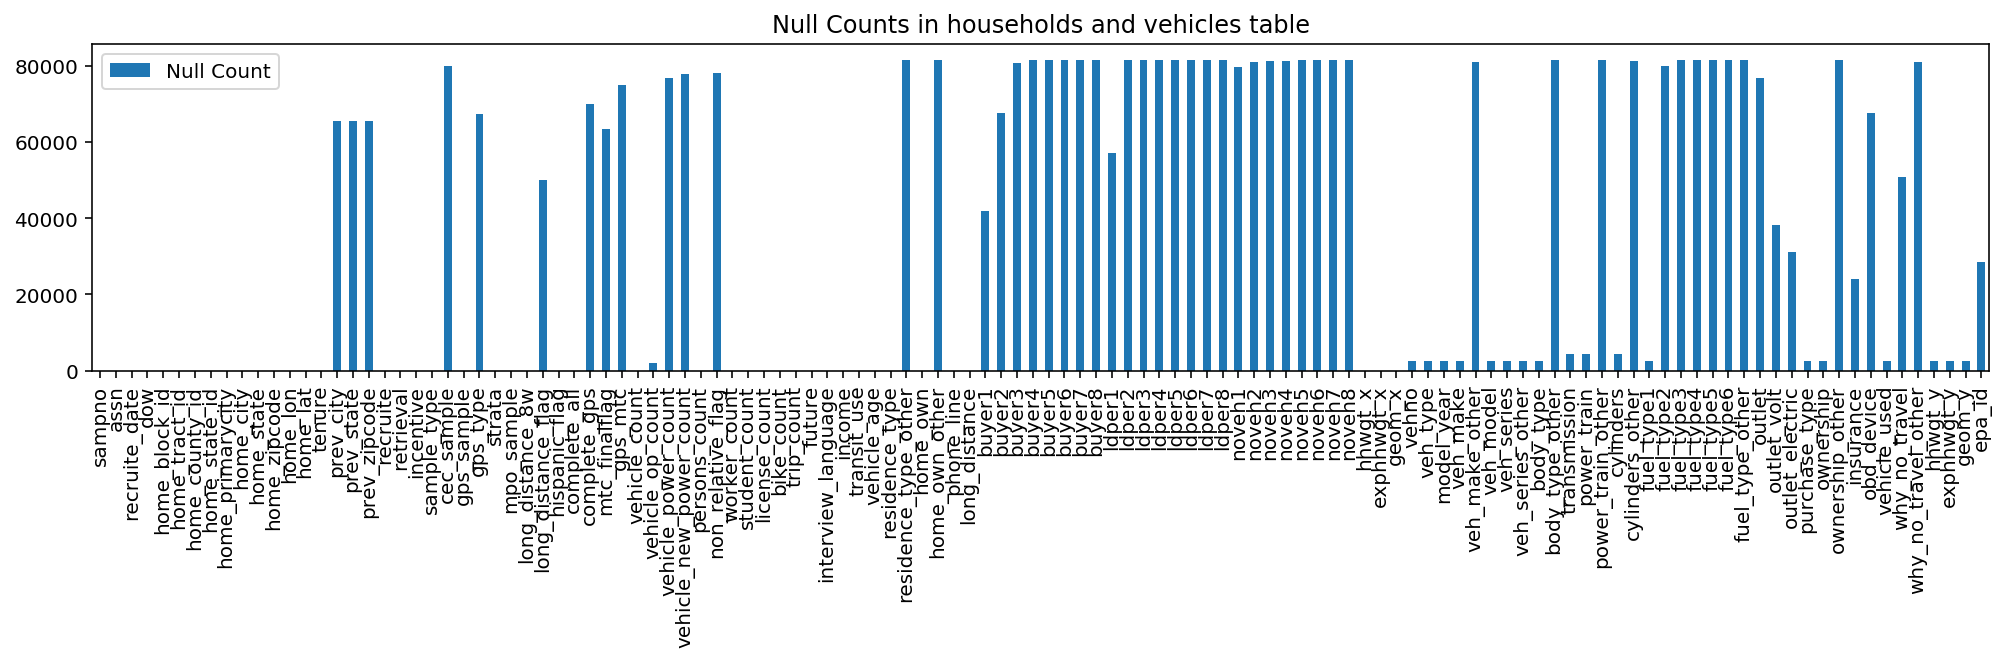

In [47]:
plot_nulls([df_households_vehicles], titles=['households and vehicles'])

### Predicting Vehicle Type
[Top](#Table-of-Contents)

**_ We want to predict vehicle type in order to find the relationship between demographic data and vehicle preference. Our demographic data includes: Education, gender, race, age, employment status, etc._**